In [182]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [183]:
data = pd.read_csv('/content/drive/MyDrive/Housing Pricing.csv')
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125


In [184]:
data.drop('Id', inplace=True, axis=1)
data.head(1)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500


In [185]:
original_features = list(data.columns)
len(original_features)

76

In [186]:
features_with_missing_values = list(data.columns[data.isna().any()])
len(features_with_missing_values)

15

# Fill in Missing Values
Create lists to hold categorical and numerical features sepatarely

In [187]:
bfill, mean_fill = [],[] 

In [188]:
for feature in features_with_missing_values:
  if data[feature].dtype == 'float64':
    # store numerical feature 
    mean_fill.append(feature)
  else:
    # store categorical feature 
    bfill.append(feature)

In [189]:
# fill missing numerical values using mean 
for feature in mean_fill:
  data[feature].fillna(data[feature].mean(), inplace=True)

In [190]:
# fill missing categorical values using next valid value (backward fill)
for feature in bfill:
  data[feature].fillna(method='bfill', inplace=True)

# Encoding the dataset

In [191]:
categorical_features = list(data.select_dtypes(include=['object']).columns)

Find set difference between original features and categorical features to obtain numerical features:


In [192]:
numerical_features = list(set(original_features) - set(categorical_features))

In [193]:
# some nominal features present in the dataset, selected by hand
nominal_features = ['Neighborhood', 'MSZoning', 'LandContour', 'Street', 'LotConfig']

Ordinal features is result of set difference between categorical and nominal:

In [194]:
ordinal_features = list(set(categorical_features) - set(nominal_features))

In [195]:
target = ['SalePrice']

In [196]:
# one-hot encode nominal features
df_nominal = pd.get_dummies(data[nominal_features])

In [197]:
# encode ordinal features
for feature in ordinal_features:
  data[feature] = data[feature].astype('category').cat.codes

df_ordinal = data[ordinal_features]

In [198]:
# form a new dataset by concatenating the encoded dataframes
encoded_dataset = pd.concat([df_nominal, df_ordinal, data[numerical_features]], axis = 1)
encoded_dataset.shape

(1460, 112)

# Standardizing the dataset

In [199]:
# remove the target from the dataset
encoded_dataset.drop('SalePrice', axis = 1, inplace = True)

In [200]:
# convert dataset to numpy array and standardize
X = encoded_dataset.to_numpy()

X_standardized = StandardScaler().fit_transform(X)
X_standardized

array([[-0.10854037, -0.03703704, -0.10526316, ...,  0.13877749,
         0.57542484, -0.06869175],
       [-0.10854037, -0.03703704, -0.10526316, ..., -0.61443862,
         1.17199212, -0.06869175],
       [-0.10854037, -0.03703704, -0.10526316, ...,  0.13877749,
         0.09290718, -0.06869175],
       ...,
       [-0.10854037, -0.03703704, -0.10526316, ...,  1.64520971,
        -0.36987111, -0.06869175],
       [-0.10854037, -0.03703704, -0.10526316, ...,  1.64520971,
        -0.86554834, -0.06869175],
       [-0.10854037, -0.03703704, -0.10526316, ...,  0.13877749,
         0.84738933, -0.06869175]])

In [201]:

# array representing the target
y = data[target]


In [202]:
# standardize the target
y = StandardScaler().fit_transform(y)
y

array([[ 0.34727322],
       [ 0.00728832],
       [ 0.53615372],
       ...,
       [ 1.07761115],
       [-0.48852299],
       [-0.42084081]])

# Feature Selection using L1

Initialize and train the L1 model. Training the model allows us to obtain the coefficients to see which features were selected.

In [203]:
regressor = LassoCV()
regressor.fit(X_standardized, y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

Get the series of coefficients from the trained model. The most penalized features will have coefficients of 0. Selected features will have coefficients not equal to 0.

79  selected features


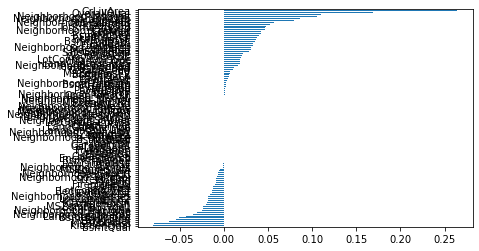

In [204]:
coefficients = pd.Series(regressor.coef_, index = encoded_dataset.columns)
sorted_coefficients = coefficients.sort_values()
sorted_coefficients.plot(kind = 'barh')

no_of_selected_features = sum(coefficients != 0)
print(no_of_selected_features," selected features")

## Removing unselected features
Create a list of rejected features (coefficient labels where coefficient is 0). Then use the list to drop the features from the dataset

In [205]:
rejected_features = []
# get rejected features
for label, value in zip(coefficients.index, coefficients.values):
  if value == 0:
    rejected_features.append(label)

df_standardized = pd.DataFrame(X_standardized, columns=encoded_dataset.columns)
X_selected = df_standardized.drop(rejected_features, axis=1)
X_selected

,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Veenker,MSZoning_C (all),MSZoning_FV,MSZoning_RM,LandContour_Bnk,LandContour_HLS,Street_Grvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,CentralAir,Exterior1st,BsmtExposure,BsmtCond,LandSlope,FireplaceQu,RoofMatl,SaleCondition,GarageCond,BldgType,Heating,MasVnrType,GarageFinish,SaleType,KitchenQual,ExterCond,BsmtFinType1,HouseStyle,ExterQual,HeatingQC,BsmtQual,Utilities,Functional,Condition2,RoofStyle,PavedDrive,YearRemodAdd,TotalBsmtSF,TotRmsAbvGrd,OpenPorchSF,FullBath,HalfBath,LowQualFinSF,3SsnPorch,ScreenPorch,OverallCond,MoSold,KitchenAbvGr,1stFlrSF,GrLivArea,OverallQual,GarageCars,BedroomAbvGr,LotArea,WoodDeckSF,Fireplaces,YearBuilt,MasVnrArea,MSSubClass,LotFrontage,BsmtHalfBath,BsmtFinSF2,BsmtFullBath,YrSold,BsmtFinSF1
0,-0.203395,-0.139832,-0.190252,-0.271163,-0.239176,-0.186352,-0.426833,-0.078757,-0.229416,-0.169981,-0.235958,-0.289638,-0.250182,-0.131991,-0.087129,-0.083045,-0.215859,-0.418955,-0.21236,-0.188311,-0.064238,-0.262324,-0.182380,-0.052414,0.263813,0.743092,0.640462,0.287800,-0.225716,1.115711,-0.125797,0.208502,0.187973,-0.411691,-0.123046,-1.238042,-0.230122,0.313867,-0.409369,0.364207,-0.407795,1.026689,-0.777976,-0.884658,-0.290552,-0.02618,0.255978,-0.03174,-0.491516,0.289745,0.878668,-0.459303,0.912210,0.216503,0.789741,1.227585,-0.120242,-0.116339,-0.270208,-0.517200,-1.599111,-0.211454,-0.793434,0.370333,0.651479,0.311725,0.163779,-0.207142,-0.752176,-0.951226,1.050994,0.511418,0.073375,-0.229372,-0.241061,-0.288653,1.107810,0.138777,0.575425
1,-0.203395,-0.139832,-0.190252,-0.271163,-0.239176,-0.186352,-0.426833,-0.078757,-0.229416,-0.169981,-0.235958,-0.289638,-0.250182,-0.131991,11.477250,-0.083045,-0.215859,-0.418955,-0.21236,-0.188311,-0.064238,-0.262324,5.483049,-0.052414,0.263813,-0.508251,-1.104081,0.287800,-0.225716,1.115711,-0.125797,0.208502,0.187973,-0.411691,-0.123046,0.388908,-0.230122,0.313867,0.795629,0.364207,-1.505270,-0.543457,0.663451,-0.884658,-0.290552,-0.02618,0.255978,-0.03174,-0.491516,0.289745,-0.429577,0.466465,-0.318683,-0.704483,0.789741,-0.761621,-0.120242,-0.116339,-0.270208,2.179628,-0.489110,-0.211454,0.257140,-0.482512,-0.071836,0.311725,0.163779,-0.091886,1.626195,0.600495,0.156734,-0.574410,-0.872563,0.451936,3.948809,-0.288653,-0.819964,-0.614439,1.171992
2,-0.203395,-0.139832,-0.190252,-0.271163,-0.239176,-0.186352,-0.426833,-0.078757,-0.229416,-0.169981,-0.235958,-0.289638,-0.250182,-0.131991,-0.087129,-0.083045,-0.215859,-0.418955,-0.21236,-0.188311,-0.064238,-0.262324,-0.182380,-0.052414,0.263813,0.743092,-0.231809,0.287800,-0.225716,1.115711,-0.125797,0.208502,0.187973,-0.411691,-0.123046,-1.238042,-0.230122,0.313867,-0.409369,0.364207,-0.407795,1.026689,-0.777976,-0.884658,-0.290552,-0.02618,0.255978,-0.03174,-0.491516,0.289745,0.830215,-0.313369,-0.318683,-0.070361,0.789741,1.227585,-0.120242,-0.116339,-0.270208,-0.517200,0.990891,-0.211454,-0.627826,0.515013,0.651479,0.311725,0.163779,0.073480,-0.752176,0.600495,0.984752,0.323060,0.073375,-0.093110,-0.241061,-0.288653,1.107810,0.138777,0.092907
3,-0.203395,-0.139832,5.256182,-0.271163,-0.239176,-0.186352,-0.426833,-0.078757,-0.229416,-0.169981,-0.235958,-0.289638,-0.250182,-0.131991,-0.087129,-0.083045,-0.215859,-0.418955,-0.21236,-0.188311,-0.064238,-0.262324,-0.182380,-0.052414,0.263813,1.055928,0.640462,-2.724304,-0.225716,-0.628334,-0.125797,-3.426284,0.187973,-0.411691,-0.123046,0.388908,1.000568,0.313867,-0.409369,0.364207,-1.505270,1.026689,0.663451,0.265476,0.852861,-0.02618,0.255978,-0.03174,-0.491516,0.289745,-0.720298,-0.687324,0.296763,-0.176048,-1.026041,-0.761621,-0.120242,-0.116339,-0.270208,-0.517200,-1.599111,-0.211454,-0.521734,0.383659,0.651479,1.650307,0.163779,-0.096897,-0.752176,0

# Train a regression model using deep feed forward ANN

## Creating the model
The input layer shape is that of the number of features in the dataset, which is 79 after feature selection.

In [206]:
model = Sequential()
model.add(Dense(128, input_shape = (X_selected.shape[1],), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32))
model.compile(Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['MAE'])


epochs = 100

Splitting the dataset into the test and train sets

In [207]:
X_train, X_test, Y_train, Y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42) 


The model is trained 70% of the dataset. The test set (remaining 30%) is passed to the model as validation data on which the loss and metric (in this case, MSE and MAE respectively) are evaluated at the end of each epoch. The model is not trained on this data, but only on the 70%

In [208]:
history = model.fit(X_train, Y_train, verbose = 0, epochs=epochs, validation_data=(X_test, Y_test))

# Testing the model on 30% of the dataset

Generate predictions from th model using the test set

In [209]:
predictions = model.predict(X_test)
predictions

array([[-0.32276398, -0.322862  , -0.32307833, ..., -0.3229882 ,
        -0.32277417, -0.32303277],
       [ 2.32933   ,  2.3298984 ,  2.3293893 , ...,  2.329757  ,
         2.3295057 ,  2.3299444 ],
       [-0.9799988 , -0.9806947 , -0.9810207 , ..., -0.98074776,
        -0.9803532 , -0.9808571 ],
       ...,
       [ 0.2904128 ,  0.29066837,  0.2905665 , ...,  0.29058766,
         0.290523  ,  0.29051375],
       [-0.7250498 , -0.7254194 , -0.7256623 , ..., -0.72553384,
        -0.7251822 , -0.72555655],
       [ 3.5847073 ,  3.585508  ,  3.5847108 , ...,  3.5853121 ,
         3.5849547 ,  3.5856898 ]], dtype=float32)

## Create a graph showing the trend in loss and metric with each epoch
The mean squared error (loss) reduces with each epoch, showing an imporovement in the model's learining

Text(0.5, 1.0, 'Final Loss: 0.003, Final MAE: 0.034')

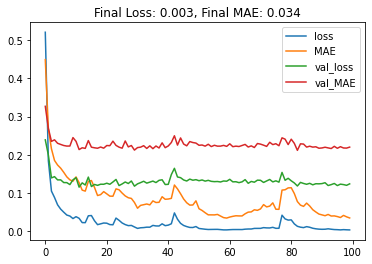

In [210]:
historydf=pd.DataFrame(history.history, index=history.epoch)
historydf.head()

final_loss=historydf['loss'].to_numpy()[-1]
final_mae=historydf['MAE'].to_numpy()[-1]

historydf.plot()
plt.title('Final Loss: %.3f, Final MAE: %.3f' % (final_loss, final_mae))